In [3]:
import segmentation.unet
import importlib
importlib.reload(segmentation.unet)

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


<module 'segmentation.unet' from 'c:\\2022_summer_intern\\automatic-gel-analysis\\backend\\segmentation\\unet\\__init__.py'>

In [25]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
import imageio
import cv2
import torchvision.transforms as transforms
import torch
from PIL import Image
import torch.nn.functional as F

from segmentation.unet import UNet, smp_UNetPlusPlus, smp_UNet
from segmentation.helper_functions.display_functions import show_segmentation

In [45]:
# original_image_path = "C:/Users/s2137314/Downloads/UVP02670July252022.tif"
original_image_path = "C:/Users/s2137314/Downloads/1kb_DNAladder_edited.png"
checkpoint_file_path = "C:/Users/s2137314/Downloads/smp-UNet-with-augmentations-checkpoint_epoch170.pth"
checkpoint_file_path_2 = "C:/Users/s2137314/Downloads/smp-UNet-no-augmentations-checkpoint_epoch180.pth"
n_channels = 1
# net = UNet(n_channels=1, n_classes=2, bilinear=False)
net = smp_UNet(
            encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=2,  # model output channels (number of classes in your dataset)
        )

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.


Model loaded from C:/Users/s2137314/Downloads/smp-UNet-with-augmentations-checkpoint_epoch170.pth
(nlabels = 14)
volume_labels: [6.42538054e+03 1.48921572e+02 1.86949024e+02 2.58956868e+02
 2.61733340e+02 6.69019635e+00 2.14090202e+02 6.30745105e+02
 2.20827455e+02 1.73352946e+02 1.73333335e+00 4.01960789e+00
 1.76090202e+02 1.53725493e+00 2.34145104e+02]


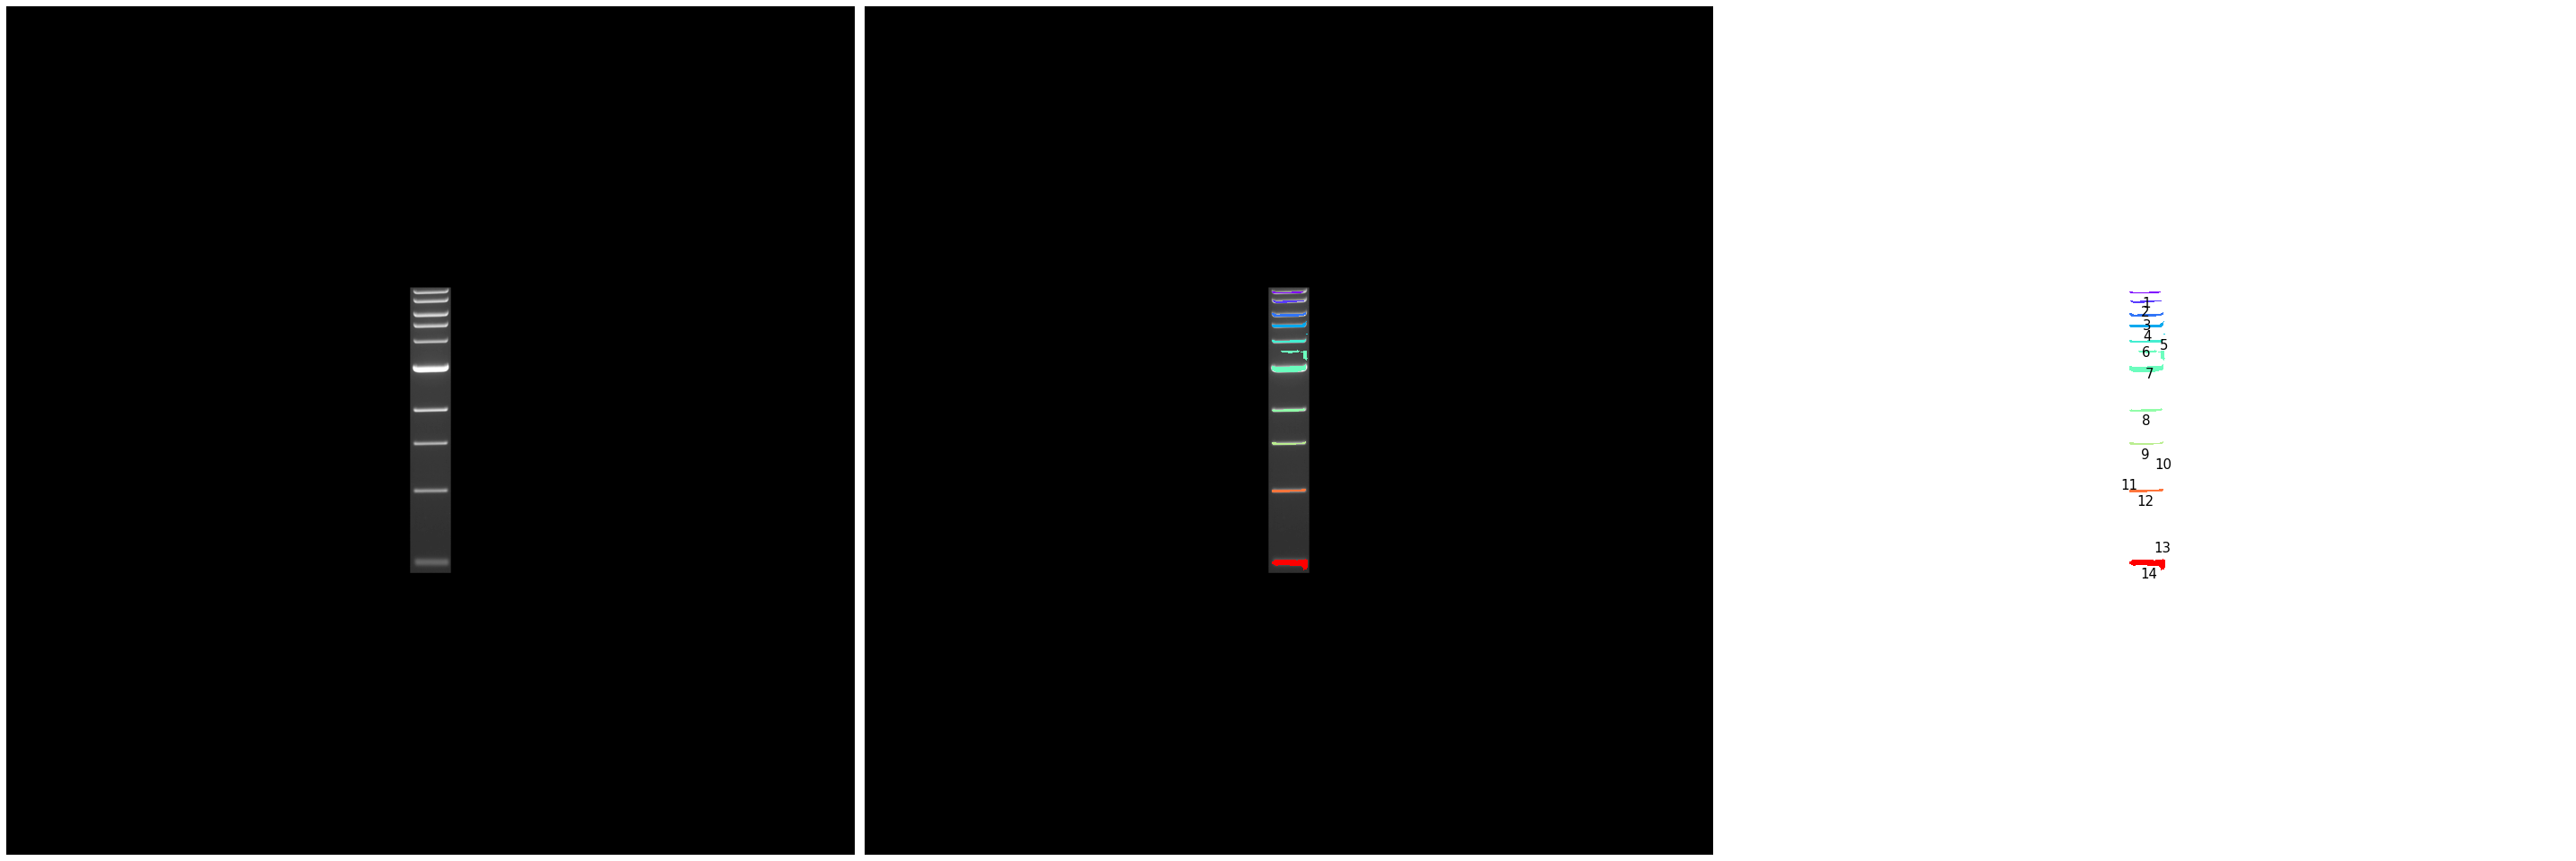

In [48]:
original_image = imageio.imread(original_image_path)

# Converting to desired number of channels
if n_channels == 1:  # Target input: 1 channel
    if original_image.shape[-1] == 3:  # Actual input: 3 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    elif original_image.shape[-1] == 4: # Actual input: 4 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2GRAY)
    # No change required for already grayscale images
elif n_channels == 3:  # Target input: 3 channels
    if original_image.shape[-1] == 4:  # Actual input: 4 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2RGB)
    elif original_image.shape[-1] != 3:  # Actual input: 1 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)


# Normalizing image
if original_image.dtype == 'uint8':
    max_val = 255
elif original_image.dtype == 'uint16':
    max_val = 65535
original_image = original_image.astype(np.float32) / (max_val - 0)

top = (1376 - original_image.shape[0]) // 2
bottom = 1376 - original_image.shape[0] - top
left = (1376 - original_image.shape[1]) // 2
right = 1376 - original_image.shape[1] - left

original_image = np.pad(original_image, pad_width=((top, bottom), (left, right)), mode='constant')


standard_image_transform = transforms.Compose([transforms.ToTensor()])
original_image_tensor = standard_image_transform(original_image)

original_image_tensor = torch.unsqueeze(original_image_tensor, dim=0)

net.train()

saved_dict = torch.load(f=checkpoint_file_path, map_location=torch.device("cpu"))
# net_saved_dict = saved_dict['network']
net.load_state_dict(saved_dict['network'])
print(f'Model loaded from {checkpoint_file_path}')

with torch.no_grad():
    # predict the mask
    mask_pred = net(original_image_tensor)
mask_pred.squeeze()
mask_pred_array = np.transpose(mask_pred.detach().squeeze().cpu().numpy(), (1, 2, 0))  # CHW to HWC
height, width = mask_pred_array.shape[0], mask_pred_array.shape[1]
threshold = 0.8
thresholded = np.zeros((height, width))
for row in range(height):
    for column in range(width):
        if mask_pred_array[row][column][0] < (1-threshold) and mask_pred_array[row][column][1] > threshold:
            thresholded[row][column] = 1



# use a boolean condition to find where pixel values are > 0.75
blobs = thresholded == 1

# label connected regions that satisfy this condition
labels, nlabels = ndimage.label(blobs, structure=[[1,1,1],[1,1,1],[1,1,1]])


# find their centres of mass. in this case I'm weighting by the pixel values in
# `img`, but you could also pass the boolean values in `blobs` to compute the
# unweighted centroids.
r, c = np.vstack(ndimage.center_of_mass(thresholded, labels, np.arange(nlabels) + 1)).T

# find their distances from the top-left corner
d = np.sqrt(r*r + c*c)


# Get coordinates for each unique band
# create array of intensities
volume_labels = np.zeros((nlabels+1), float)
area_labels = np.zeros((nlabels+1), int)

for h in range(height):
    for w in range(width):
        volume_labels[labels[h][w]] += original_image[h][w]  # index = label, value += intensity(between 0 and 1)
        area_labels[labels[h][w]] += 1
print(f'(nlabels = {nlabels})\nvolume_labels: {volume_labels}')

# plot
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(40, 40))
# ax[0].imshow(thresholded)
ax[0].imshow(original_image, cmap='gray')

ax[1].imshow(original_image, cmap='gray')
ax[1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
# for ri, ci, di in zip(r, c, d):
#     label = int(labels[int(ri)][int(ci)])
#     ax[1].annotate(f'{label}', xy=(ci, ri),  xytext=(0, -5),
#                textcoords='offset points', ha='center', va='top',
#                fontsize=30)

ax[2].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
for ri, ci, di, count in zip(r, c, d, range(nlabels)):
#     ax[1].annotate('', xy=(0, 0), xytext=(ci, ri),
#                    arrowprops={'arrowstyle':'<-', 'shrinkA':0})
#     ax[1].annotate(f'label={label}, concentration={volume_labels[label]}', xy=(ci, ri),  xytext=(0, -5),
#     textcoords='offset points', ha='center', va='top',
    label = int(labels[int(ri)][int(ci)])
    ax[2].annotate(f'{count+1}', xy=(ci, ri),  xytext=(0, -5),
               textcoords='offset points', ha='center', va='top',
               fontsize=15)
for aa in ax.flat:
    aa.set_axis_off()
fig.tight_layout()
plt.savefig('C:/Users/s2137314/Downloads/save as pdf.pdf')
plt.show()

In [56]:
real_volumes = []
analyzer_volumes = []
filter_indices = [1, 2, 3, 4, 6, 7, 8, 9, 12, 14]
measured_volumes = volume_labels[filter_indices]

In [57]:
1 2 3 4 5 7 8 9 12 14

SyntaxError: invalid syntax (2222667394.py, line 1)

Real // Measured // GelAnalyzer
[[1.27272727 0.96078434 0.        ]
 [1.27272727 1.20612273 1.11282051]
 [1.51515152 1.67068947 1.44786325]
 [1.27272727 1.68860219 1.26666667]
 [1.         1.38122711 1.        ]
 [3.78787879 4.06932326 3.22222222]
 [1.45454545 1.42469326 1.29401709]
 [1.09090909 1.11840611 0.96410256]
 [1.27272727 1.13606582 0.94017094]
 [1.27272727 1.51061357 0.80512821]]


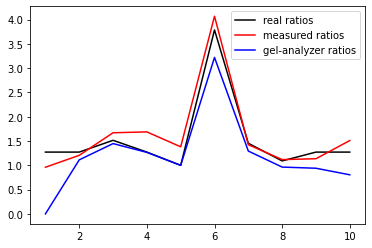

In [58]:
measured_ratios = []
real_ratios = []
analyzer_ratios = []
real_volumes = [42, 42, 50, 42, 33, 125, 48, 36, 42, 42]
# measured_volumes = volume_labels[1:]
analyzer_volumes = [0, 651, 847, 741, 585, 1885, 757, 564, 550, 471]
base_value_real = 33
base_value_measured = 155
base_value_analyzer = 585

for r, m, a in zip(real_volumes, measured_volumes, analyzer_volumes):
    real_ratios.append(r/base_value_real)
    measured_ratios.append(m/base_value_measured)
    analyzer_ratios.append(a/base_value_analyzer)
print("Real // Measured // GelAnalyzer")
print(np.c_[real_ratios, measured_ratios, analyzer_ratios])
x = range(1,11)
plt.plot(x, real_ratios, color='black', label='real ratios')
plt.plot(x, measured_ratios, color='red', label='measured ratios')
plt.plot(x, analyzer_ratios, color='blue', label='gel-analyzer ratios')
plt.legend()


In [40]:
volume_labels[6]

285.1568674445152

In [41]:
volume_labels[7]

342.1803973913193

In [42]:
volume_labels[10]

282.0235332250595

In [47]:
nlabels

14